In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
from skimage.io import imread, imshow

In [145]:
class_num, image_num = 40, 10
orl_face = []
for i in range(1, class_num+1):
    temp = []
    for j in range(1, image_num+1):
        temp.append(imread('./orl_faces/s{}/{}.pgm'.format(i, j)))
    orl_face.append(temp)

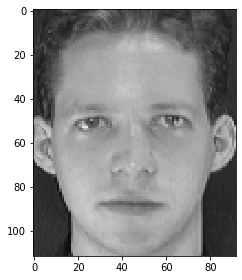

In [146]:
imshow(orl_face[0][0])

In [147]:
train_data, train_label = [], []
test_data, test_label = [], []

for i in range(len(orl_face)):
    num = random.randint(5, 7)
    train = random.sample(orl_face[i], num)
    train_data = train_data + train
    train_label = train_label + [i+1 for _ in range(num)]

    temp = []
    for j in range(len(orl_face[i])):
        flag = True
        for k in range(len(train)):
            if (orl_face[i][j] == train[k]).all():
                flag = False
                break
        if flag:
            temp.append(orl_face[i][j])
                        
    test_data = test_data + temp
    test_label = test_label + [i+1 for _ in range(10-num)]

对数据集进行处理，$x^{(i)}$为列向量：

In [148]:
train_data = np.array(train_data)
train_data = train_data.reshape(train_data.shape[0], -1).transpose()
train_label = np.array(train_label)
test_data = np.array(test_data)
test_data = test_data.reshape(test_data.shape[0], -1).transpose()
test_label = np.array(test_label)

Center the data (subtract the mean $\mu=\frac{1}{N}\sum^N_{i=1}x^{(i)}$ from each data point)

In [149]:
train_data = train_data - train_data.mean(axis=1).reshape(-1, 1)
test_data = test_data - test_data.mean(axis=1).reshape(-1, 1)

Compute the covariance matrix:
$$
S=\frac{1}{N}\sum^N_{i=1}x^{(i)}x^{(i)^T}=\frac{1}{N}XX^T
$$

In [150]:
N = train_data.shape[1]
S = np.dot(train_data, train_data.T) / N

The eigendecomposition of the covariance matrix S

In [151]:
W0, V0 = np.linalg.eig(S)

In [241]:
W, V = np.real(W0), np.real(V0)
# W, V = W0, V0

In [262]:
index = (-W).argsort()
W = W[index]
V = V[:, index]

In [263]:
def get_H(x, y):
    m, n = x.shape
    P = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            P[i, j] = np.dot(x[i], x[j]) * y[i] * y[j]
    return P

In [264]:
def get_w(alpha, x, y):
    w = np.zeros(x.shape)
    w[:, 0] = x[:, 0] * alpha * y
    w[:, 1] = x[:, 1] * alpha * y
    return np.sum(w, axis=0)

In [265]:
def get_b(alpha, w, x, y):
    m, n = x.shape
    index = []
    for i in range(m):
        if alpha[i] > 0:
            index.append(i)
    index = np.array(index)
    
    x = x[index]
    y = y[index]

    return (y - np.dot(x, w)).sum() / len(index)

In [266]:
def solve_dual(x, y):
    m, n = x.shape
    P = get_H(x, y)
    q = np.ones(m) * (-1)
    G, h = None, None
    A = y.astype('float')
    b = np.zeros(1)
    lb = np.zeros(m)
    ub = None
    
    alpha = solve_qp(P, q, G, h, A, b, lb, ub, solver='cvxopt')
    # print(alpha)

    w = get_w(alpha, x, y)
    b = get_b(alpha, w, x, y)

    return w, b

In [267]:
def pred(w, b, x):
    return np.dot(x, w) + b

In [268]:
def get_x_y(Z, label, label_1, label_2):
    index_1 = np.where(label==label_1)[0]
    index_2 = np.where(label==label_2)[0]

    y_1 = [1 for _ in range(index_1.shape[0])]
    y_2 = [-1 for _ in range(index_2.shape[0])]
    y = np.array(y_1 + y_2)

    index = np.concatenate((index_1, index_2)).flatten()
    x = Z[:, index].transpose()
    
    return x, y

In [318]:
def multi_classify_SVM(V, k):
    U = V[:, :k]

    train_Z = np.dot(U.T, train_data)
    test_Z = np.dot(U.T, test_data)

    w_b_list = []
    index_list = []
    for i in range(1, class_num+1):
        for j in range(i+1, class_num+1):
            index_list.append([i-1, j-1])
            x, y = get_x_y(train_Z, train_label, i, j)
            w, b = solve_dual(x, y)
            w_b_list.append([w, b])

    pred_res = []
    for i in range(test_label.shape[0]):
        temp = np.zeros(class_num)
        for idx in range(len(w_b_list)):
            res = pred(w_b_list[idx][0], w_b_list[idx][1], test_Z.transpose()[i])
            if res >= 0:
                temp[index_list[idx][0]] += 1
            else:
                temp[index_list[idx][1]] += 1
        pred_res.append(temp.argmax()+1)
        # print(temp.argmax()+1, test_label[i])
    pred_res = np.array(pred_res)

    return (pred_res == test_label).sum() / test_label.shape[0]

In [2]:
multi_classify_SVM(V, 10)

0.8233532934131736

In [3]:
multi_classify_SVM(V, 20)

0.9514970059880239

In [5]:
multi_classify_SVM(V, 30)

1.0